Import Library

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
import matplotlib.pyplot as plt

Divide Dataset into Train, Validation and Test

In [ ]:
DATASET_PATH = './speech_commands_v0.01/'

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory = DATASET_PATH,
    batch_size = 64,
    output_sequence_length = 16000,
    validation_split = 0.2,
    subset = "both",
    seed = 0
)

test_ds = val_ds.shard(num_shards = 2, index = 0)
val_ds = val_ds.shard(num_shards = 2, index = 1)

Found 64727 files belonging to 31 classes.
Using 51782 files for training.
Using 12945 files for validation.


Get Label Names From Train Dataset

In [ ]:
label_names = np.array(train_ds.class_names)
print(label_names)

['_background_noise_' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five'
 'four' 'go' 'happy' 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one'
 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow'
 'yes' 'zero']


Preprocessing Audio (Squeeze)

In [ ]:
def squeeze(audio, label):
    audio = tf.squeeze(audio, axis=-1)
    return audio, label

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

Preprocessing Audio (Get Spectogram and Make Spectogram)

In [ ]:
def get_spectrogram(audio):
    spectrogram = tf.signal.stft(audio, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]

    return spectrogram


def make_spectrogram_ds(ds):
    return ds.map(map_func = lambda audio, label: (get_spectrogram(audio), label), num_parallel_calls=tf.data.AUTOTUNE)


train_spectrogram_ds = make_spectrogram_ds(train_ds)
test_spectrogram_ds = make_spectrogram_ds(test_ds)
val_spectrogram_ds = make_spectrogram_ds(val_ds)

train_spectrogram_ds= train_spectrogram_ds.cache().shuffle(2030).prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Making CNN Model

In [ ]:
for sample_ds, sample_ds_labels in test_spectrogram_ds.take(1):
    break

input_shape = sample_ds.shape[1:]
num_labels = len(label_names)

norm_layer = layers.Normalization()
norm_layer.adapt(
    data = train_spectrogram_ds.map(map_func=lambda spec, label:spec)
)

model = models.Sequential(
    [
    layers.Input(shape = input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation = "relu"),
    layers.Conv2D(64, 3, activation = "relu"),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation = "relu"),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
    ]

)

In [ ]:
model.compile(
    metrics = ["accuracy"],
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam()
)

Training Model

In [ ]:
history = model.fit(
    train_spectrogram_ds,
    validation_data = val_spectrogram_ds,
    epochs = 50,
    callbacks = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2)
)

Epoch 1/50


810/810 ━━━━━━━━━━━━━━━━━━━━ 148s 181ms/step - accuracy: 0.2541 - loss: 2.6472 - val_accuracy: 0.7183 - val_loss: 1.0808
Epoch 2/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 112s 139ms/step - accuracy: 0.6286 - loss: 1.2367 - val_accuracy: 0.7823 - val_loss: 0.7820
Epoch 3/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 114s 141ms/step - accuracy: 0.7197 - loss: 0.9118 - val_accuracy: 0.8127 - val_loss: 0.6634
Epoch 4/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 116s 143ms/step - accuracy: 0.7699 - loss: 0.7539 - val_accuracy: 0.8278 - val_loss: 0.6085
Epoch 5/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 117s 144ms/step - accuracy: 0.7956 - loss: 0.6535 - val_accuracy: 0.8284 - val_loss: 0.5993
Epoch 6/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 117s 144ms/step - accuracy: 0.8161 - loss: 0.5783 - val_accuracy: 0.8410 - val_loss: 0.5611
Epoch 7/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 110s 135ms/step - accuracy: 0.8333 - loss: 0.5227 - val_accuracy: 0.8453 - val_loss: 0.5553
Epoch 8/50
810/810 ━━━━━━━━━━━━━━━━━━━━ 118s 145ms/step - accuracy: 0.8470 - loss: 0.48

Count Word Error Rate From Predicted Label and True Label in Test Dataset

In [ ]:
import jiwer
y_pred = model.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)

def convert_to_label(labels):
    return [label_names[label.numpy()] for label in labels]

y_pred = convert_to_label(y_pred)
y_true_label = []
for _, label in test_spectrogram_ds:
    y_true_label.append(label)

y_true = tf.concat(y_true_label, axis = 0)
y_true = convert_to_label(y_true)
count = 0
total = 0

for i, (true_label, predict_label) in enumerate(zip(y_true, y_pred)):
    print("True_label : ", true_label, " Predicted_label : ", predict_label)
    count+=1
    wer = jiwer.wer(true_label, predict_label)
    # print(f"Word Error Rate: {wer*100} %")
    total+=wer


  1/102 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step

102/102 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
True_label :  stop  Predicted_label :  stop
True_label :  seven  Predicted_label :  three
True_label :  cat  Predicted_label :  cat
True_label :  eight  Predicted_label :  eight
True_label :  stop  Predicted_label :  stop
True_label :  six  Predicted_label :  six
True_label :  two  Predicted_label :  two
True_label :  wow  Predicted_label :  yes
True_label :  no  Predicted_label :  no
True_label :  six  Predicted_label :  six
True_label :  four  Predicted_label :  four
True_label :  up  Predicted_label :  six
True_label :  no  Predicted_label :  no
True_label :  two  Predicted_label :  go
True_label :  right  Predicted_label :  right
True_label :  six  Predicted_label :  six
True_label :  tree  Predicted_label :  tree
True_label :  go  Predicted_label :  bed
True_label :  seven  Predicted_label :  seven
True_label :  cat  Predicted_label :  cat
True_label :  eight  Predicted_label :  eight
True_label :  one  Predicted_label :  one
True_label : 

Graph Accuracy

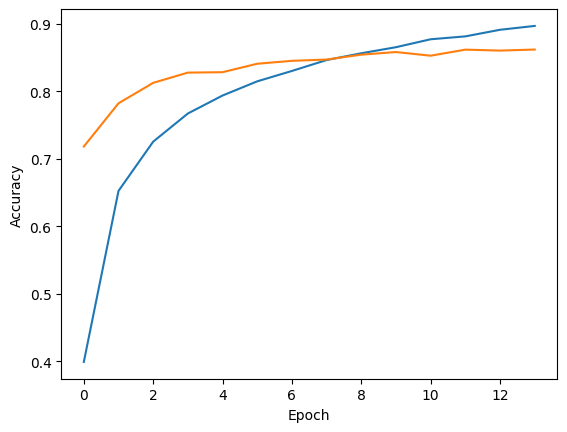

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

Graph Loss

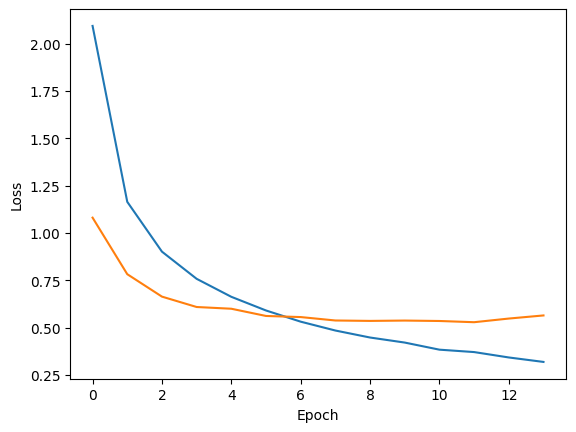

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Word Error Rate

In [ ]:
print(f"Word Error Rate: {(total/count)*100} %")

Word Error Rate: 13.207838296559174 %
